# Машинное обучение в бизнесе

## Цель: выбрать наиболее перспективный регион для бурения скважины

## Данные:

|признак|описание|
|---|---|
|id|идентификатор скважины|
|f0|признак1|
|f1|признак2|
|f2|признак3|
|product|объём запасов в скважине (тыс. баррелей)|

## Условия задачи:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей,  поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Содержание:

* [1. Импорт библиотек.](#1)
* [2. Первичный анализ признаков](#2)
* [3. Анализ целевой переменной](#3)
* [4. Задаем модель, разбиваем данные на трейн/тест](#4)
* [5. Предсказания в регионах, анализ к-ов, rmse](#5)
* [6. Расчет достаточного объёма сырья для безубыточной разработки новой скважины(сравнение с средним запасом в регионе)](#6) 
* [7. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели](#7) 
* [8. Оценка рисков с помощью Bootstrap](#8) 
    
## Выводы
    
* почти линейная зависимость между f2 и объемом запасов в регионе1(возможна утечка данных)
* в регионе1 рапспределение близко к равномерному (присутствуют тяжелые хвосты, данные клипировали)
* в регионе0 и регионе2 распределения близки к нормальныму(присутствуют тяжелые хвосты)
* во всех регионах рассчитанный минимальный объем сырья больше среднего

|регион|средняя прибыль|95% доверительный пнтервал для среднего|вероятность убытков, %|
|---|---|---|---|
|регион1|450 млн.руб.|[9.57139633e+09 9.79114185e+09]|4.9|
|регион2|477 млн.руб.|[4.03960700e+09 4.42488363e+09]|0.3|
|регион3|368 млн.руб.|[1.01687115e+10 1.03845548e+10]|7|

* регион2 является наиболее перспективным(максимальная прибыль, минимальный риск)

## 0. Импорт библиотек

<a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, train_test_split, KFold
from sklearn.metrics import mean_squared_error

## 1. Загрузите и подготовьте данные. Поясните порядок действий.

In [2]:
df0 = pd.read_csv('datasets/geo_data_0.csv', index_col = ['id'])
df1 = pd.read_csv('datasets/geo_data_1.csv', index_col = ['id'])
df2 = pd.read_csv('datasets/geo_data_2.csv', index_col = ['id'])

<a id='2'></a>

Корреляции признаков

1) РЕГИОН0
Корреляция признаков:
         f0     f1     f2  product
f0      NaN -0.441 -0.003    0.144
f1      NaN    NaN  0.002   -0.192
f2      NaN    NaN    NaN    0.484
product NaN    NaN    NaN      NaN


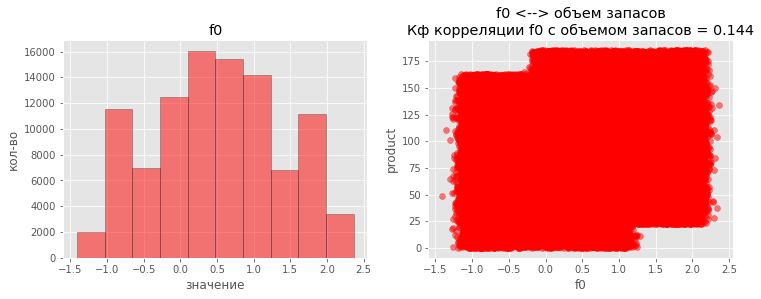

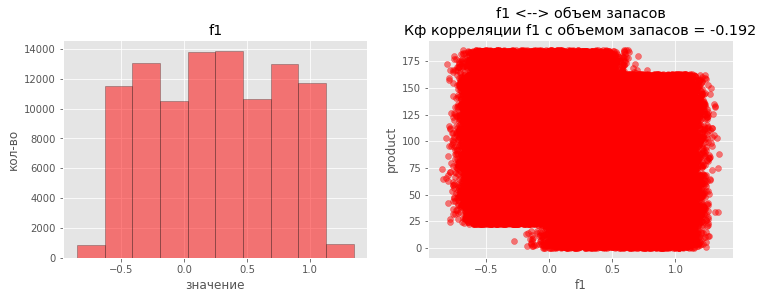

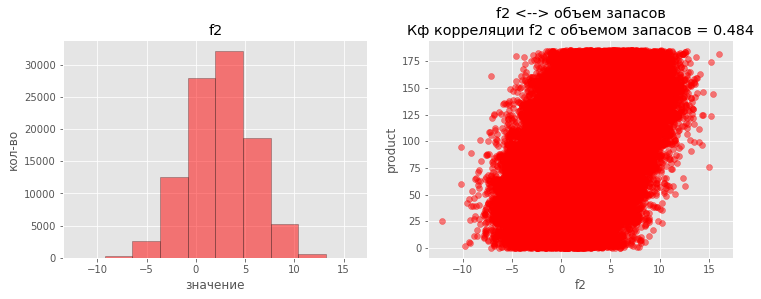

----------------------------------------------------------------------------------------------------------

2) РЕГИОН1
Корреляция признаков:
         f0     f1     f2  product
f0      NaN  0.182 -0.002   -0.030
f1      NaN    NaN -0.003   -0.010
f2      NaN    NaN    NaN    0.999
product NaN    NaN    NaN      NaN


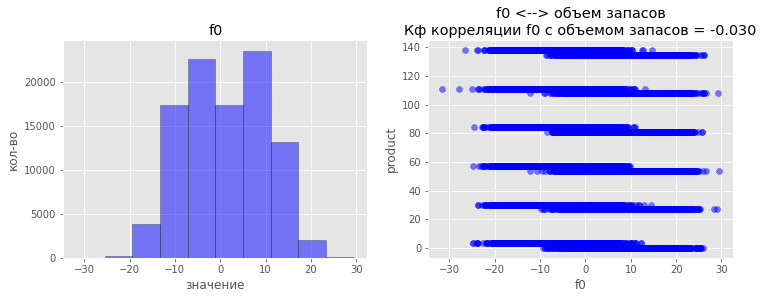

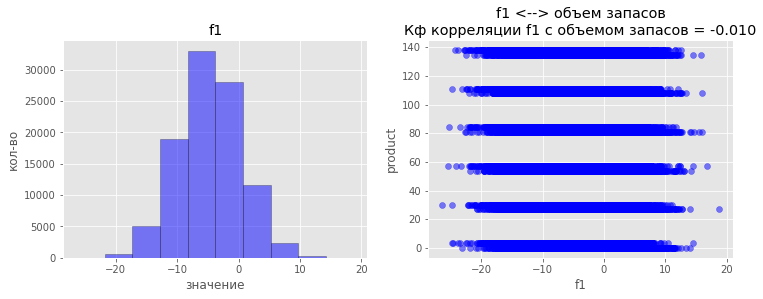

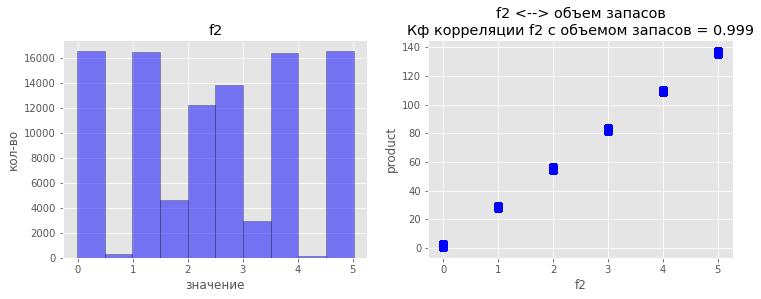

----------------------------------------------------------------------------------------------------------

3) РЕГИОН2
Корреляция признаков:
         f0     f1     f2  product
f0      NaN  0.001 -0.000   -0.002
f1      NaN    NaN  0.001   -0.001
f2      NaN    NaN    NaN    0.446
product NaN    NaN    NaN      NaN


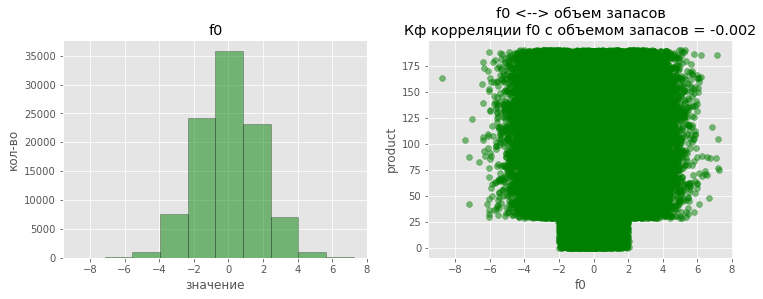

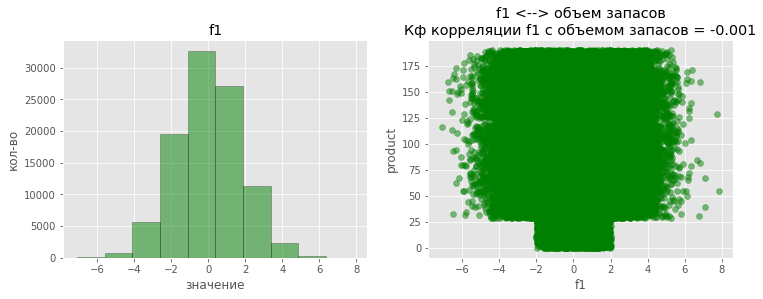

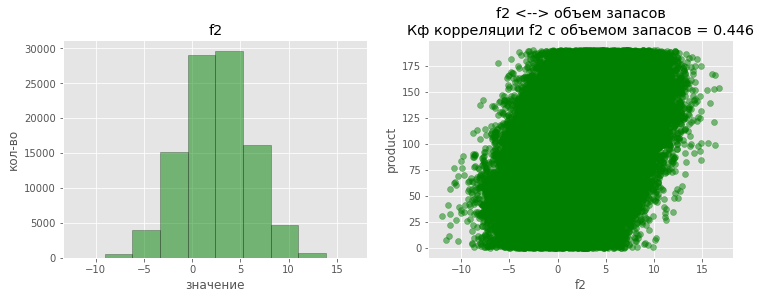

----------------------------------------------------------------------------------------------------------



In [3]:
print('Корреляции признаков\n')
# проходим по регионам
for i, (color, name, df) in enumerate(zip(('red', 'blue', 'green'),
                                          ('регион0', 'регион1', 'регион2'),\
                                          (df0, df1, df2))):
    # вычисляем корреляции
    corr = df.corr().round(3)
    # берем верхнюю часть таблицы
    corr_triu = corr.where(np.triu(np.ones_like(corr).astype(np.bool), k = 1)) 
    # выводим  результат
    print('{}) {}'.format(i+1, str.upper(name)))
    print('Корреляция признаков:\n{}'.format(corr_triu))
    
    # проходим по признакам
    for feat in ('f0', 'f1', 'f2'):        
        # задаем фигуру
        fig = plt.figure(figsize = (12, 4))
        # задаем подграфик
        ax0 = plt.subplot(1, 2, 1)
        # гистограмма признака
        df[feat].hist(ax = ax0, edgecolor='black', alpha = .5, color = color)
        plt.title(feat)
        plt.xlabel('значение')
        plt.ylabel('кол-во')
        #  задаем подграфик   
        ax1 = plt.subplot(1, 2, 2)
        # объем запасов от признака
        plt.scatter(df[feat], df['product'], alpha = .5, color = color)
        plt.xlabel(feat)
        plt.ylabel('product')
        # кф корреляции
        corr_w_target = df[[feat]].corrwith(df['product']).values[0]        
        plt.title('{} <--> объем запасов\nКф корреляции {} с объемом запасов = {:.3f}'.format(feat, feat, corr_w_target))
        plt.show()
    print('----------------------------------------------------------------------------------------------------------\n')

#### почти линейная зависимость между f2 и объемом запасов в регионе1(линейная регрессия будет давать наилучшие предсказания)

<a id='3'></a>

In [4]:
_proucts_in_regions_df = pd.DataFrame(np.r_[np.column_stack([df0['product'].values, np.repeat(0, len(df0))]),
                                      np.column_stack([df1['product'].values, np.repeat(1, len(df1))]),
                                      np.column_stack([df2['product'].values, np.repeat(2, len(df2))])],\
                                     columns = ['объем запасов', 'регион']) 
_proucts_in_regions_df['регион'] = _proucts_in_regions_df['регион'].astype(int)
product0 = _proucts_in_regions_df[_proucts_in_regions_df['регион'] == 0]['объем запасов']
product1 = _proucts_in_regions_df[_proucts_in_regions_df['регион'] == 1]['объем запасов']
product2 = _proucts_in_regions_df[_proucts_in_regions_df['регион'] == 2]['объем запасов']

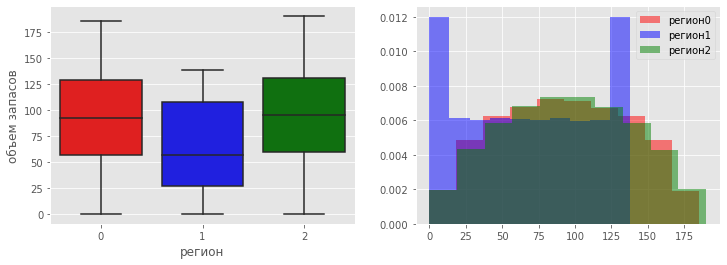

In [5]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data = _proucts_in_regions_df, y = 'объем запасов', x = 'регион', palette = {0:'red', 1:'blue', 2:'green'})

plt.subplot(1, 2, 2)
product0.hist(density= 1, alpha = .5, color = 'red')
product1.hist(density= 1, alpha = .5, color = 'blue')
product2.hist(density= 1, alpha = .5, color = 'green')
plt.legend([f'регион{0}', f'регион{1}', f'регион{2}'])
plt.show()

* в регионе1 рапспределение близко к равномерному (присутствуют тяжелые хвосты, данные клипировали)
* в регионе0 и регионе2 распределения близки к нормальныму(присутствуют тяжелые хвосты)

## 2. Обучите и проверьте модель для каждого региона

<a id='4'></a>

In [6]:
linreg = LinearRegression(normalize = True)
SEED = 13
TEST_SHARE = .25

### 2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.


In [7]:
xxyy_L = []
for df in (df0, df1, df2):
    X_TR, X_VAL, Y_TR, Y_VAL = train_test_split(df.drop('product', 1).values,\
                                                df['product'].values,\
                                                test_size = TEST_SHARE,\
                                                random_state = SEED)
    xxyy_L.append((X_TR, X_VAL, Y_TR, Y_VAL))

### 2.2. Обучите модель и сделайте предсказания на валидационной выборке.
### 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.
### 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

<a id='5'></a>

In [8]:
# список с предсказаниями на отложенной
target_predictions_L = []
# список с правильными ответами на отложенной
target_trues_L = []
# список с RMSE 
rmse_L = np.array([])
print('Предсказания, RMSE\n-----------------------------------------------------------------')
for i, (xtr, xval, ytr, yval) in enumerate(xxyy_L):
    linreg.fit(xtr, ytr)
    ypred = linreg.predict(xval)
    ymean = ypred.mean()
    target_predictions_L.append(ypred)    
    target_trues_L.append(yval)
    
    rmse = np.sqrt(mean_squared_error(yval, ypred))
    rmse_L = np.append(rmse_L, rmse)
    coefs = linreg.coef_.flatten()
    
    print('{}) регион{}'\
          .format(i+1, i))
    print('\tсредний запас предсказанного cырья(тыс. баррелей) = {:.2f}\n\tRMSE(тыс. баррелей) = {:.2f}'\
          .format(ymean, rmse))
    print('\tk0={:.2f}, k1={:.2f}, k2={:.2f}\n'\
          .format(*coefs))

Предсказания, RMSE
-----------------------------------------------------------------
1) регион0
	средний запас предсказанного cырья(тыс. баррелей) = 92.59
	RMSE(тыс. баррелей) = 37.69
	k0=3.82, k1=-14.11, k2=6.60

2) регион1
	средний запас предсказанного cырья(тыс. баррелей) = 69.03
	RMSE(тыс. баррелей) = 0.89
	k0=-0.14, k1=-0.02, k2=26.95

3) регион2
	средний запас предсказанного cырья(тыс. баррелей) = 94.96
	RMSE(тыс. баррелей) = 40.02
	k0=-0.12, k1=-0.08, k2=5.75



### 2.5. Проанализируйте результаты.

In [9]:
for i, (_predictsions, _rmse) in enumerate(zip(target_predictions_L, rmse_L)):
    print('регион{} | RMSE/y_pred_mean = {:.2f}'.format(i, _rmse / np.mean(_predictsions)))

регион0 | RMSE/y_pred_mean = 0.41
регион1 | RMSE/y_pred_mean = 0.01
регион2 | RMSE/y_pred_mean = 0.42


#### в регионе1 rmse - наименьшая, в регионах 1 и 2 - примерно одинаковые

## 3. Подготовьтесь к расчёту прибыли

### Условия задачи:
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### 3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

In [10]:
# кол-во исследуемых точек
WELL_POINTS = 500

# кол-во лучших точек для разработки
N_BEST = 200

SAMPLE_SIZE = 500

N_SAMPLES = 1000

# бюджет
TOTAL_BUDGET = 10*1e9

# бюджет на разработку одного месторождения
DOF = 50*10**6

# прибыль от одного барреля
ONE_BARREL_PROFIT = 450

# максимально допустимая вероятность убытков
RISK_TRESHOLD = 0.025

# уровень значимости
ALPHA = 0.05

### 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

<a id='6'></a>

In [11]:
MIN_BARRRELS_TRESHOLD = DOF / ONE_BARREL_PROFIT
MAX_DOF_COUNT = int(TOTAL_BUDGET / DOF)

print('минимальное количество баррелей которые необходимы для разарботки одного месторождения = {:.2f}'\
      .format(MIN_BARRRELS_TRESHOLD))
print('максимальное количество месторождений можно разработать = {}\n'\
      .format(MAX_DOF_COUNT))

print('минимальное количество баррелей которые необходимы для разарботки одного месторождения к среднему запасу в регионе0: {:.2f}'\
          .format(MIN_BARRRELS_TRESHOLD / (df0['product'].mean()*1000)))
print('минимальное количество баррелей которые необходимы для разарботки одного месторождения к среднему запасу в регионе1: {:.2f}'\
          .format(MIN_BARRRELS_TRESHOLD / (df1['product'].mean()*1000)))
print('минимальное количество баррелей которые необходимы для разарботки одного месторождения к среднему запасу в регионе3: {:.2f}'\
          .format(MIN_BARRRELS_TRESHOLD / (df2['product'].mean()*1000)))

минимальное количество баррелей которые необходимы для разарботки одного месторождения = 111111.11
максимальное количество месторождений можно разработать = 200

минимальное количество баррелей которые необходимы для разарботки одного месторождения к среднему запасу в регионе0: 1.20
минимальное количество баррелей которые необходимы для разарботки одного месторождения к среднему запасу в регионе1: 1.61
минимальное количество баррелей которые необходимы для разарботки одного месторождения к среднему запасу в регионе3: 1.17


во всех регионах рассчитанный минимальный объем сырья больше среднего

## 4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

<a id='7'></a>

In [12]:
def _get_revenue(trues, predictions, top_count):
    '''
    trues - истинные значения
    predictions - предсказанные значения
    top_count - используемые значения
    '''
    pred_np = np.array(predictions)
    true_np = np.array(trues)
    idx_argsorted = np.argsort(pred_np)[::-1][:top_count]
    return ONE_BARREL_PROFIT*1000*true_np[idx_argsorted].sum() - TOTAL_BUDGET

## 5. Посчитайте риски и прибыль для каждого региона
### 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

<a id='8'></a>

In [15]:
L = []
for region, target_trues, target_predictions in zip(('регион1', 'регион2', 'регион3'), target_trues_L, target_predictions_L):
    # выборки топ N прибылей 
    bootstrap_revenues = np.array([])
    # запускаем цикл по кол-ву выборок
    for bootstrap_seed in range(N_SAMPLES):
        # семплируем таргет, фиксируя сид
        target_subsample = pd.Series(target_trues).sample(SAMPLE_SIZE, replace=True, random_state=bootstrap_seed)
        # находим предсказания по индексу таргета
        probs_subsample = pd.Series(target_predictions).loc[target_subsample.index]
        # оцениваем прибыль для 200 лучших
        bootstrap_revenues = np.append(bootstrap_revenues, _get_revenue(target_subsample, probs_subsample, N_BEST))  
    L.append(bootstrap_revenues)

### 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль


регион1
cредняя прибыль = 450 млн.руб.
вероятность убытков = 4.9%
95% доверительный интервал для среднего = [-3.72995538e+08 -2.01818964e+08]

регион2
cредняя прибыль = 477 млн.руб.
вероятность убытков = 0.3%
95% доверительный интервал для среднего = [-92037711.88787246  27996785.67105261]

регион3
cредняя прибыль = 368 млн.руб.
вероятность убытков = 7.0%
95% доверительный интервал для среднего = [-4.12656853e+08 -2.35999425e+08]



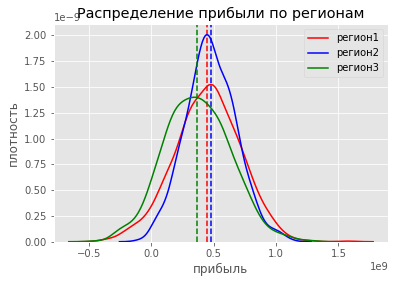

In [17]:
for color, l, region in zip(('red', 'blue', 'green'), L, ('регион1', 'регион2', 'регион3')):
    print(region)
    print('cредняя прибыль = {:.0f} млн.руб.'.format(l.mean()/1e6))
    print('вероятность убытков = {:.1%}'.format((l<0).mean()))
    print('95% доверительный интервал для среднего = {}\n'.format(str(np.percentile(l, [ALPHA/2, 1-ALPHA/2]))))
    sns.kdeplot(l, color = color, label = region)
    plt.axvline(l.mean(), linestyle='--', color = color)
plt.title('Распределение прибыли по регионам')
plt.xlabel('прибыль')
plt.ylabel('плотность')
plt.show()

### 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор


регион2 - самый перспрективный